# Stop Sign Detector

In [1]:
# Imports

# Standard library
import pickle
from pathlib import Path

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

2023-04-27 16:10:18.197548: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 16:10:18.517472: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 16:10:18.518567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 16:10:19.654651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Prepare data

In [2]:
data_dir = Path("images")
output_dir = Path("output")

image_count = len(list(data_dir.glob("*/*.[jJ][pP][gG]")))
print(f"There are {image_count} images in the dataset")

There are 69 images in the dataset


In [3]:
# Load data (split into training (85%), validation (15%))
batch_size = 32
img_height = 120
img_width = 160

# (90%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="training",
    seed=42,
    label_mode="binary",
    batch_size=batch_size,
    image_size=(img_height, img_width),
)

# (10% - one image of each class)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="validation",
    seed=42,
    label_mode="binary",
    batch_size=batch_size,
    image_size=(img_height, img_width),
)

Found 69 files belonging to 2 classes.
Using 59 files for training.
Found 69 files belonging to 2 classes.
Using 10 files for validation.


In [4]:
# Describe the dataset

class_names = train_ds.class_names
print(f"Class names: {class_names}")

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
valid_ds_size = tf.data.experimental.cardinality(valid_ds).numpy()
print(f"Training data size: {train_ds_size}")
print(f"Validation data size: {valid_ds_size}")

Class names: ['is', 'not']
Number of classes: 2
Training data size: 2
Validation data size: 1


2023-04-27 16:10:21.242425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [59]
	 [[{{node Placeholder/_4}}]]
2023-04-27 16:10:21.243604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [59]
	 [[{{node Placeholder/_0}}]]


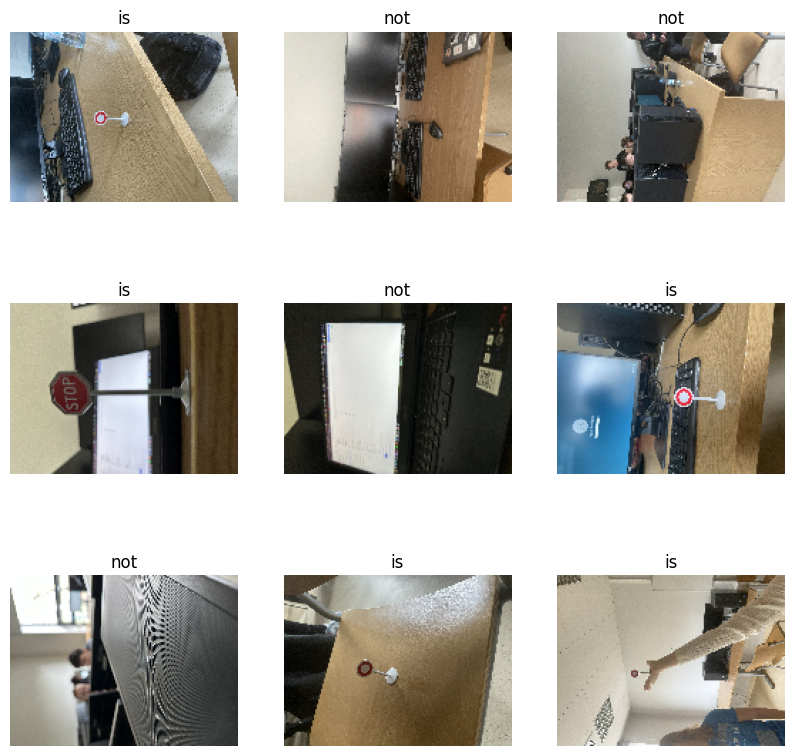

In [5]:
# Visualize the data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

2023-04-27 16:10:24.378576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [59]
	 [[{{node Placeholder/_4}}]]
2023-04-27 16:10:24.379075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [59]
	 [[{{node Placeholder/_0}}]]


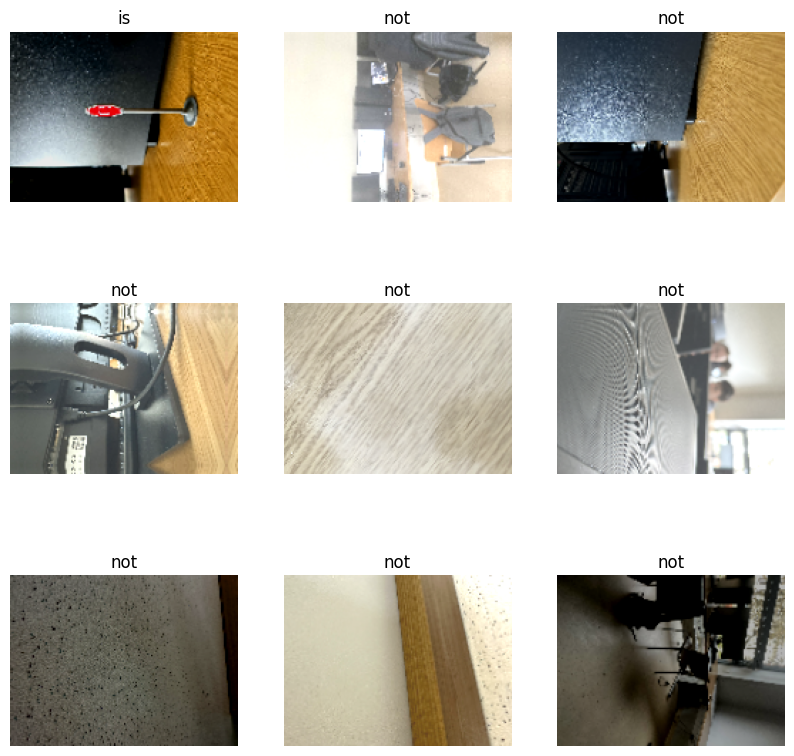

In [6]:
# Data augmentation

augument_layer = Sequential(
    [
        layers.RandomZoom(0.15),
        layers.RandomFlip(mode="horizontal_and_vertical"),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.3),
        layers.Lambda(lambda x: tf.image.random_saturation(x, 0.9, 1.5)),
    ],
    name="augument_layer",
)

# Show some augmented images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augument_layer(images)[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

2023-04-27 16:10:28.398522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [59]
	 [[{{node Placeholder/_4}}]]
2023-04-27 16:10:28.399154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [59]
	 [[{{node Placeholder/_0}}]]


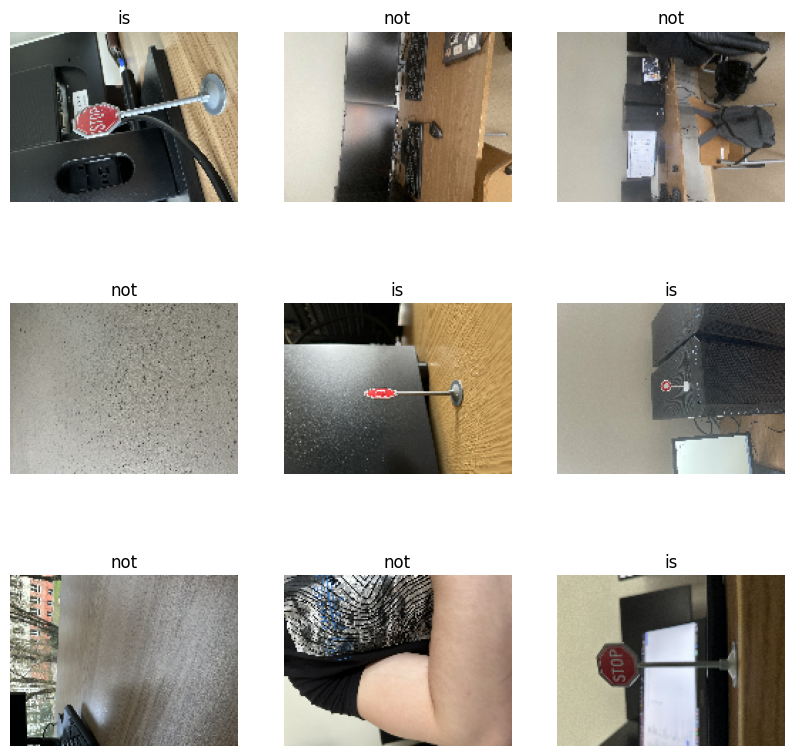

In [7]:
# Data normalization

normalize_layer = Sequential(
    [
        layers.experimental.preprocessing.Resizing(
            img_height, img_width, interpolation="bilinear"
        ),
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
    ]
)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(normalize_layer(images[i]).numpy().squeeze(), cmap="gray")
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE


def preprocess(ds, shuffle=False, augument=False, repeat=False):
    # Repeat the dataset forever
    if repeat:
        ds = ds.repeat()

    # Apply data augmentation
    if augument:
        ds = ds.map(lambda x, y: (augument_layer(x), y), num_parallel_calls=AUTOTUNE)

    # Apply normalization
    ds = ds.map(lambda x, y: (normalize_layer(x), y), num_parallel_calls=AUTOTUNE)

    # Shuffle the dataset
    if shuffle:
        ds = ds.shuffle(100, reshuffle_each_iteration=True)

    # Use buffered prefetching to load images from disk without having I/O become blocking
    return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Define the model

model = Sequential(
    [
        layers.Conv2D(
            16,
            3,
            padding="same",
            activation="relu",
            input_shape=(img_height, img_width, 3),
        ),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(24, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1),
    ],
    name="Sign_Detection_Model",
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Show the model summary
model.summary()

Model: "Sign_Detection_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 20, 6

In [10]:
# Setup checkpoints
checkpoint_path = output_dir / "checkpoints" / "cp-{epoch:04d}.ckpt"
checkpoint_dir = checkpoint_path.parent
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq="epoch",
)

In [11]:
raise Exception("Stop right there!")

Exception: Stop right there!

In [12]:
epochs = 15
steps_per_epoch = 200
validation_steps = 50

# If checkpoint exists, load it and continue training
if checkpoint_dir.exists():
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    print(f"Loaded checkpoint: {latest}")

history = model.fit(
    preprocess(train_ds, shuffle=True, augument=True, repeat=True),
    validation_data=preprocess(valid_ds, shuffle=True, augument=True, repeat=True),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    batch_size=batch_size,
    callbacks=[checkpoint_callback],
)

# Save the model & history
model.save(output_dir / "model.h5")
with open(output_dir / "history.pkl", "wb") as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/15


2023-04-27 16:10:48.820339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype resource
	 [[{{node Placeholder/_22}}]]
2023-04-27 16:10:48.822664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype resource
	 [[{{node Placeholder/_24}}]]
2023-04-27 16:11:02.332472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11 of 100
2023-04-27 16:11:11.524509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 21 of 100
2023-04-27 16:11:21.811326: I tensorflow/cor

200/200 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.8642

2023-04-27 16:16:53.308616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10]
	 [[{{node Placeholder/_4}}]]
2023-04-27 16:16:53.311410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_23' with dtype resource
	 [[{{node Placeholder/_23}}]]
2023-04-27 16:17:03.890452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 16:17:14.186536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 43 of 100
2023-04-27 16:17:24.092943: I tens


Epoch 1: saving model to output/checkpoints/cp-0001.ckpt
200/200 [==============================] - 447s 2s/step - loss: 0.2478 - accuracy: 0.8642 - val_loss: 0.0881 - val_accuracy: 0.9540
Epoch 2/15
200/200 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9757

2023-04-27 16:22:37.279130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 100
2023-04-27 16:22:47.003234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 34 of 100
2023-04-27 16:22:57.113018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 66 of 100
2023-04-27 16:23:06.910528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 97 of 100
2023-04-27 16:23:07.943485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 2: saving model to output/checkpoints/cp-0002.ckpt
200/200 [==============================] - 333s 2s/step - loss: 0.0601 - accuracy: 0.9757 - val_loss: 0.0273 - val_accuracy: 0.9900
Epoch 3/15
200/200 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9885

2023-04-27 16:28:03.535180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 16:28:13.134169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 30 of 100
2023-04-27 16:28:23.369015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 46 of 100
2023-04-27 16:28:33.239599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 77 of 100
2023-04-27 16:28:40.544293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 3: saving model to output/checkpoints/cp-0003.ckpt
200/200 [==============================] - 326s 2s/step - loss: 0.0303 - accuracy: 0.9885 - val_loss: 0.0164 - val_accuracy: 0.9980
Epoch 4/15
200/200 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9988

2023-04-27 16:33:26.008719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 100
2023-04-27 16:33:36.014054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 32 of 100
2023-04-27 16:33:46.007588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 48 of 100
2023-04-27 16:33:56.010286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 100
2023-04-27 16:34:05.688551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 79 of 100
2023-04-27 16:34:15.962668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 95 of 100
2023-04-27 16:34:18.566052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 4: saving model to output/checkpoints/cp-0004.ckpt
200/200 [==============================] - 323s 2s/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0077 - val_accuracy: 0.9980
Epoch 5/15
200/200 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9958

2023-04-27 16:38:28.940916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 16:38:38.840521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 31 of 100
2023-04-27 16:38:49.013099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47 of 100
2023-04-27 16:38:59.343984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 63 of 100
2023-04-27 16:39:09.307349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 78 of 100
2023-04-27 16:39:19.146145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 94 of 100
2023-04-27 16:39:23.112829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 5: saving model to output/checkpoints/cp-0005.ckpt
200/200 [==============================] - 363s 2s/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0241 - val_accuracy: 0.9980
Epoch 6/15
200/200 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9990

2023-04-27 16:44:04.625950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 16:44:14.664544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 30 of 100
2023-04-27 16:44:25.061817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 45 of 100
2023-04-27 16:44:34.676333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 100
2023-04-27 16:44:44.702877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 100
2023-04-27 16:44:54.261100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 90 of 100
2023-04-27 16:45:00.845586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 6: saving model to output/checkpoints/cp-0006.ckpt
200/200 [==============================] - 336s 2s/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 3.7173e-04 - val_accuracy: 1.0000
Epoch 7/15
200/200 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9941

2023-04-27 16:49:02.458220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 100
2023-04-27 16:49:12.538457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 32 of 100
2023-04-27 16:49:22.409224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 46 of 100
2023-04-27 16:49:32.309409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 100
2023-04-27 16:49:42.572596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 77 of 100
2023-04-27 16:49:52.603846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 93 of 100
2023-04-27 16:49:57.542484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 7: saving model to output/checkpoints/cp-0007.ckpt
200/200 [==============================] - 298s 1s/step - loss: 0.0237 - accuracy: 0.9941 - val_loss: 0.0245 - val_accuracy: 0.9880
Epoch 8/15
200/200 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9993

2023-04-27 16:54:10.348236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 16:54:20.359529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 31 of 100
2023-04-27 16:54:30.596411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47 of 100
2023-04-27 16:54:40.480307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 62 of 100
2023-04-27 16:54:50.447450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 78 of 100
2023-04-27 16:55:00.437755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 93 of 100
2023-04-27 16:55:04.862927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 8: saving model to output/checkpoints/cp-0008.ckpt
200/200 [==============================] - 308s 2s/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 9/15
200/200 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9861

2023-04-27 16:59:22.853795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 16:59:33.185492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 31 of 100
2023-04-27 16:59:42.799897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 45 of 100
2023-04-27 16:59:52.752970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 100
2023-04-27 17:00:02.709245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 100
2023-04-27 17:00:12.913761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 90 of 100
2023-04-27 17:00:19.726031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 9: saving model to output/checkpoints/cp-0009.ckpt
200/200 [==============================] - 313s 2s/step - loss: 0.0314 - accuracy: 0.9861 - val_loss: 0.2350 - val_accuracy: 0.8920
Epoch 10/15
200/200 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9774

2023-04-27 17:04:26.633565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 100
2023-04-27 17:04:36.504395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 32 of 100
2023-04-27 17:04:46.547959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 48 of 100
2023-04-27 17:04:56.618234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 64 of 100
2023-04-27 17:05:06.707988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 80 of 100
2023-04-27 17:05:16.660645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 96 of 100
2023-04-27 17:05:19.159019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 10: saving model to output/checkpoints/cp-0010.ckpt
200/200 [==============================] - 303s 2s/step - loss: 0.0578 - accuracy: 0.9774 - val_loss: 0.0242 - val_accuracy: 0.9940
Epoch 11/15
200/200 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9966

2023-04-27 17:09:24.479296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 17:09:34.599521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 30 of 100
2023-04-27 17:09:44.219710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 45 of 100
2023-04-27 17:09:54.778422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 100
2023-04-27 17:10:04.656370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 100
2023-04-27 17:10:14.231830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 90 of 100
2023-04-27 17:10:21.068175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 11: saving model to output/checkpoints/cp-0011.ckpt
200/200 [==============================] - 298s 1s/step - loss: 0.0098 - accuracy: 0.9966 - val_loss: 0.0706 - val_accuracy: 0.9900
Epoch 12/15
200/200 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9976

2023-04-27 17:14:30.298939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 100
2023-04-27 17:14:40.179381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 31 of 100
2023-04-27 17:14:50.627825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 47 of 100
2023-04-27 17:15:00.240727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 100
2023-04-27 17:15:10.341407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 100
2023-04-27 17:15:20.155223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 91 of 100
2023-04-27 17:15:26.390154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 12: saving model to output/checkpoints/cp-0012.ckpt
200/200 [==============================] - 306s 2s/step - loss: 0.0048 - accuracy: 0.9976 - val_loss: 0.0039 - val_accuracy: 0.9960
Epoch 13/15
200/200 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9993

2023-04-27 17:19:35.062741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 14 of 100
2023-04-27 17:19:45.178542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 29 of 100
2023-04-27 17:19:55.140622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 44 of 100
2023-04-27 17:20:05.604217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 100
2023-04-27 17:20:15.311872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 75 of 100
2023-04-27 17:20:25.080216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 90 of 100
2023-04-27 17:20:31.476546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 13: saving model to output/checkpoints/cp-0013.ckpt
200/200 [==============================] - 305s 2s/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0221 - val_accuracy: 0.9940
Epoch 14/15
200/200 [==============================] - ETA: 0s - loss: 6.1973e-04 - accuracy: 0.9998

2023-04-27 17:24:37.780682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 100
2023-04-27 17:24:47.643438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 30 of 100
2023-04-27 17:24:57.559124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 44 of 100
2023-04-27 17:25:07.624954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 59 of 100
2023-04-27 17:25:17.626355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 74 of 100
2023-04-27 17:25:27.839683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 89 of 100
2023-04-27 17:25:35.173893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 14: saving model to output/checkpoints/cp-0014.ckpt
200/200 [==============================] - 303s 2s/step - loss: 6.1973e-04 - accuracy: 0.9998 - val_loss: 0.1181 - val_accuracy: 0.9800
Epoch 15/15
200/200 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9986

2023-04-27 17:29:40.707690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 100
2023-04-27 17:29:50.869592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 31 of 100
2023-04-27 17:30:00.673571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 45 of 100
2023-04-27 17:30:10.346235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 100
2023-04-27 17:30:20.776914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 76 of 100
2023-04-27 17:30:30.486820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 91 of 100
2023-04-27 17:30:36.332406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 15: saving model to output/checkpoints/cp-0015.ckpt
200/200 [==============================] - 303s 2s/step - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.0174 - val_accuracy: 0.9940


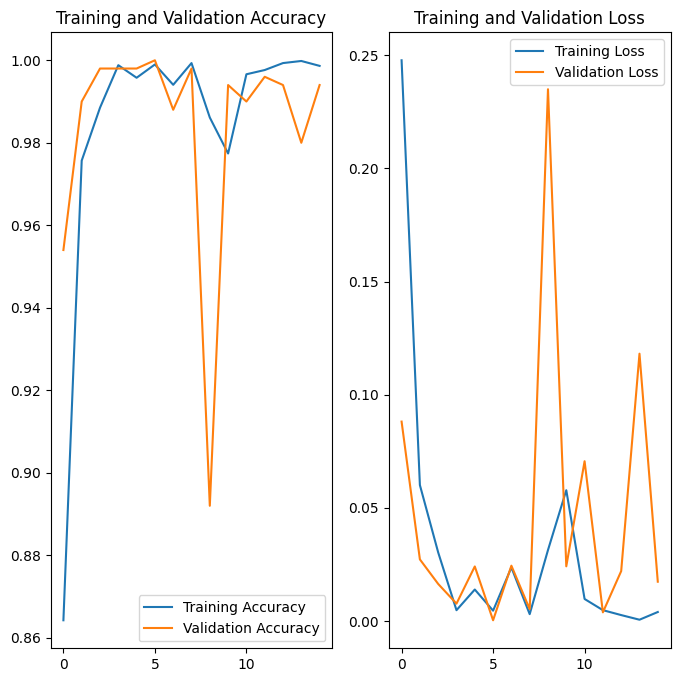

In [13]:
# Plot the training history
with open(output_dir / "history.pkl", "rb") as f:
    history = pickle.load(f)

acc = history["accuracy"]
val_acc = history["val_accuracy"]

loss = history["loss"]
val_loss = history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

2023-04-27 17:31:53.363118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-04-27 17:31:53.364275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 280ms/step
              precision    recall  f1-score   support

          is       1.00      1.00      1.00         6
         not       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



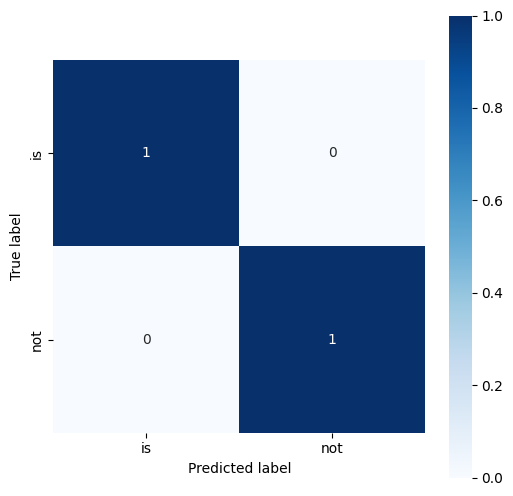

In [14]:
# Show some evaluation stats
test_ds = valid_ds

y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.append(labels.numpy())
    y_pred.append(model.predict(normalize_layer(images)).squeeze())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_pred = (y_pred > 0.5).astype(int)

cr = classification_report(y_true, y_pred, target_names=class_names)
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

print(cr)

plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    square=True,
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

2023-04-27 17:31:55.431677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [59]
	 [[{{node Placeholder/_0}}]]
2023-04-27 17:31:55.432660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [59]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step


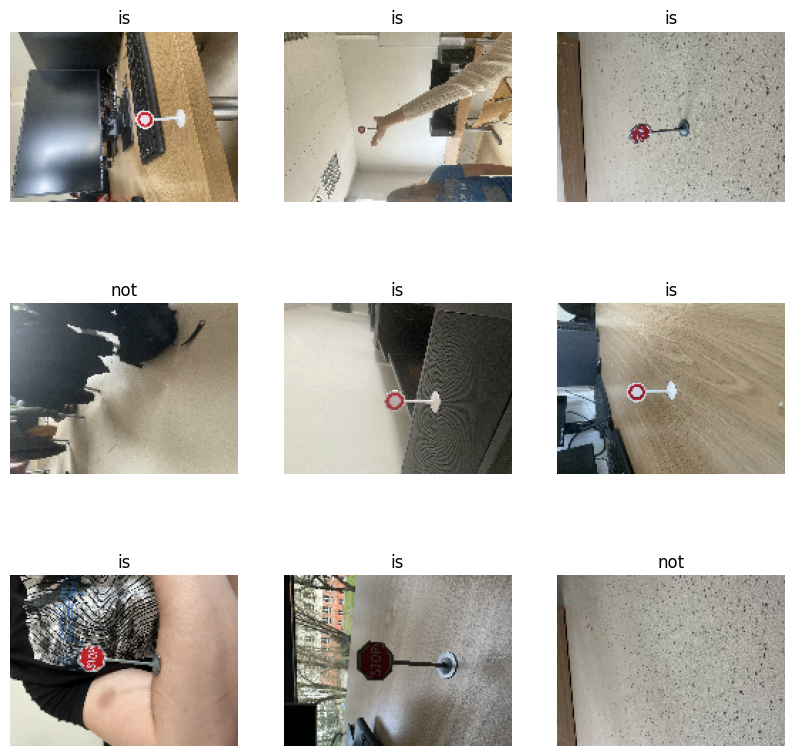

In [15]:
# Show some predictions
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(normalize_layer(images[i]).numpy().squeeze(), cmap="gray")
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

        # Make predictions
        prediction = model.predict(tf.expand_dims(normalize_layer(images[i]), axis=0))[
            0
        ][0]
        plt.xlabel(f"Prediction: {prediction:.2f}")